In [29]:
import pandas as pd
import numpy as np
import yaml
import matplotlib.pyplot as plt

In [ ]:
%matplotlib inline

# Summary

### Available Data
- current congress members committee membership .yaml
- Congress trade records
- Congress committees
- Stock Meta Data

### Goal:
- join dataframes together so that congress committees are associated with the respective congress person's trading record
- join stock meta data to trading records as well
- explore data and determine non-null records we ahve after all merging is completed
- use Google's universal sentence encoder to determine semantic similarity between commitee and stock meta information

## Utilities

In [39]:
def plot_group_counts(df: pd.DataFrame, column: str):
    """
    Groups the DataFrame by the specified column and plots the count of each group.
    """
    # Group by the specified column and count the occurrences
    group_counts = df.groupby(column).size()


    # Plotting
    plt.bar(group_counts.index,group_counts)
    plt.xlabel(column)
    plt.ylabel('Counts')
    plt.title(f'Count of each group in {column}')
    plt.show()

## Load Data

In [40]:
stock_meta_df = pd.read_csv("data/finviz_4-12-23.csv")

stock_meta_df = stock_meta_df[["ticker","full_name", "industry", "country", "Market Cap"]]
display(stock_meta_df.info())
display(stock_meta_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2751 entries, 0 to 2750
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   ticker      2751 non-null   object
 1   full_name   2751 non-null   object
 2   industry    2751 non-null   object
 3   country     2751 non-null   object
 4   Market Cap  2751 non-null   object
dtypes: object(5)
memory usage: 107.6+ KB


None

,ticker,full_name,industry,country,Market Cap
0,EBTC,"Enterprise Bancorp, Inc.",Banks - Regional,USA,372.11M
1,PROV,"Provident Financial Holdings, Inc.",Banks - Regional,USA,95.26M
2,DFP,Flaherty & Crumrine Dynamic Preferred and Inco...,Closed-End Fund - Debt,USA,375.64M
3,STM,STMicroelectronics N.V.,Semiconductors,Switzerland,46.42B
4,F,Ford Motor Company,Auto Manufacturers,USA,49.84B


In [48]:
congress_trades_df = pd.read_csv("data/congress_trades_all.csv")
congress_trades_df.rename(columns={"Representative": "name"}, inplace=True)
congress_trades_df[["TransactionDate","ReportDate"]] = \
    congress_trades_df[["TransactionDate","ReportDate"]].apply(pd.to_datetime)

congress_trades_df["TimeToReport"] = congress_trades_df["ReportDate"] - congress_trades_df["TransactionDate"]
print(congress_trades_df.info())

print(f"First transaction: {congress_trades_df['TransactionDate'].min()}")
print(f"Last transaction: {congress_trades_df['TransactionDate'].max()}")

print(f'Unique Tickers Traded: {len(congress_trades_df["Ticker"].unique())}')
print(f'QTY Congress People: {len(congress_trades_df["name"].unique())}')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22620 entries, 0 to 22619
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype          
---  ------           --------------  -----          
 0   ReportDate       22261 non-null  datetime64[ns] 
 1   TransactionDate  22620 non-null  datetime64[ns] 
 2   Ticker           22620 non-null  object         
 3   name             22620 non-null  object         
 4   Transaction      22620 non-null  object         
 5   Amount           22620 non-null  float64        
 6   House            22620 non-null  object         
 7   Range            22620 non-null  object         
 8   TimeToReport     22261 non-null  timedelta64[ns]
dtypes: datetime64[ns](2), float64(1), object(5), timedelta64[ns](1)
memory usage: 1.6+ MB
None
First transaction: 2014-07-25 00:00:00
Last transaction: 2023-03-03 00:00:00
Unique Tickers Traded: 1585
QTY Congress People: 218


,ReportDate,TransactionDate,Ticker,name,Transaction,Amount,House,Range,TimeToReport
0,2020-04-16,2020-03-18,COTY,Gilbert Cisneros,Sale,1001.0,Representatives,"$1,001-$15,000",29 days
1,2020-01-10,2019-12-06,COTY,Gilbert Cisneros,Purchase,1001.0,Representatives,"$1,001-$15,000",35 days
2,2019-09-11,2019-08-14,COTY,Gilbert Cisneros,Sale,1001.0,Representatives,"$1,001-$15,000",28 days
3,2019-09-16,2019-08-13,COTY,Dean Phillips,Sale,1001.0,Representatives,"$1,001-$15,000",34 days
4,2019-04-16,2019-03-14,COTY,Gilbert Cisneros,Purchase,1001.0,Representatives,"$1,001-$15,000",33 days


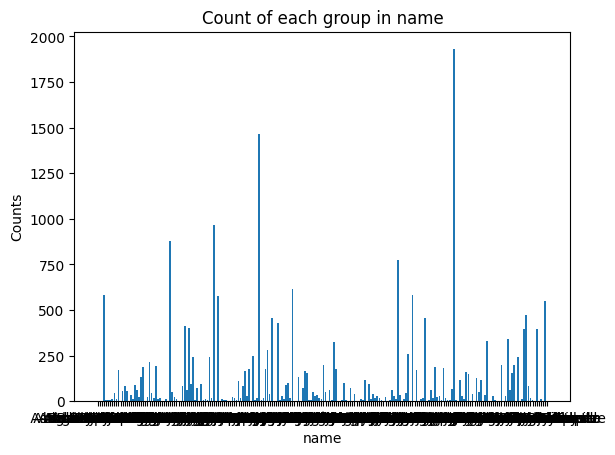

Top 10 Most Trades Placed: name
David Perdue          1930
 Josh Gottheimer      1467
 Gilbert Cisneros      966
 Dean Phillips         881
 Susie Lee             774
 Lois Frankel          613
 Alan S. Lowenthal     585
 Thomas Suozzi         584
 Greg Gianforte        578
Tommy Tuberville       552
dtype: int64


In [47]:
grouped_df = congress_trades_df.groupby("name").size()

plot_group_counts(congress_trades_df, "name")
print(f"Top 10 Most Trades Placed: {grouped_df.sort_values(ascending=False).head(10)}")

TypeError: the dtypes of parameters x (timedelta64[ns]) and width (float64) are incompatible

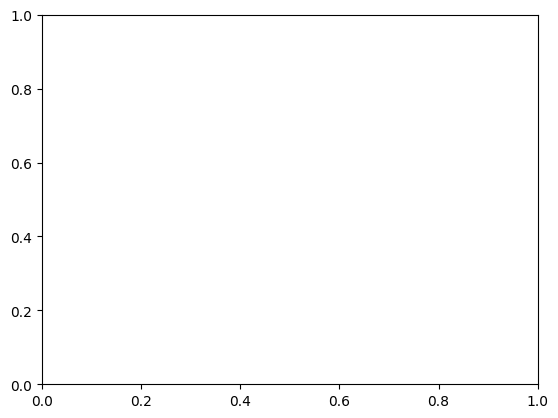

In [51]:
grouped_df = congress_trades_df.groupby("TimeToReport").size()
plot_group_counts(congress_trades_df,"TimeToReport")
